In [1]:
import pandas as pd
import covasim as cv
import altair as alt
import numpy as np
import datetime

Covasim 0.26.7 (2020-04-10) — © 2020 by IDM


# Ground truth

We will use JH dataset to get time series of infections and deaths

In [2]:
state = "Washington"
pop_size = 7614893

In [3]:
df_deaths = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")
df_confirmed = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")

In [4]:
WA_cases = df_confirmed[df_confirmed["Province_State"] == state]
WA_deaths = df_deaths[df_confirmed["Province_State"] == state]

In [5]:
def get_time_series(df, col_n):
    vals = df[df.columns[col_n:]].values
    return np.sum(vals, axis=0)

WA_cases_ts = get_time_series(WA_cases, col_n=11)
WA_deaths_ts = get_time_series(WA_deaths, col_n=12)

In [6]:
ground_truth = pd.DataFrame(columns=["date", "cases", "deaths"])
ground_truth["date"] = pd.to_datetime(WA_cases.columns[11:])
ground_truth["cases"] = WA_cases_ts
ground_truth["deaths"] = WA_deaths_ts
ground_truth.head(10)

,date,cases,deaths
0,2020-01-22,1,0
1,2020-01-23,1,0
2,2020-01-24,1,0
3,2020-01-25,1,0
4,2020-01-26,1,0
5,2020-01-27,1,0
6,2020-01-28,1,0
7,2020-01-29,1,0
8,2020-01-30,1,0
9,2020-01-31,1,0


In [7]:
base = alt.Chart(ground_truth).properties(width=550)
cases = base.mark_line().encode(
    x='date',
    y='cases',
)
deaths = base.mark_line().encode(
    x='date',
    y='deaths',
)
cases + deaths

alt.LayerChart(...)

# Simulation params

In [8]:
pop_infected = 1000
beta = 0.015
asymp_factor = 0.8
frac_pos_tests = 0.25
w_att_mar04 = 0.7
w_att_mar12 = 0.4
w_att_mar23 = 0.2
s_att_mar12 = 0.0
c_att_mar23 = 0.2

# Setting up interventions

In [9]:
start_day = datetime.datetime.strptime("3/01/2020", "%m/%d/%Y").date()

date_mar04 = datetime.datetime.strptime("3/04/2020", "%m/%d/%Y").date()
date_mar12 = datetime.datetime.strptime("3/12/2020", "%m/%d/%Y").date()
date_mar23 = datetime.datetime.strptime("3/23/2020", "%m/%d/%Y").date()

day_mar04 = int( ( date_mar04 - start_day ).days )
day_mar12 = int( ( date_mar12 - start_day ).days )
day_mar23 = int( ( date_mar23 - start_day ).days )

In [10]:
closures = cv.change_beta( 
      days   =[  day_mar04,   day_mar12,   day_mar12,   day_mar23,   day_mar23],
      changes=[w_att_mar04, s_att_mar12, w_att_mar12, w_att_mar23, c_att_mar23],
      layers =[        'w',         's',         'w',         'w',         'c']
    )

# Run sim

In [11]:
simParams = { "start_day"     : start_day,
              "n_days"        : 120,
              "pop_type"      : "synthpops",
              "pop_size"      : 100000,
              "pop_infected"  : pop_infected,
              "beta"          : beta,
              "asymp_factor"  : asymp_factor,
              "interventions" : closures,
              "rescale": True,
              "pop_scale": pop_size
            }

  Creating 100000 people...
  Created 100000 people, average age 37.20 years
  Plotting...


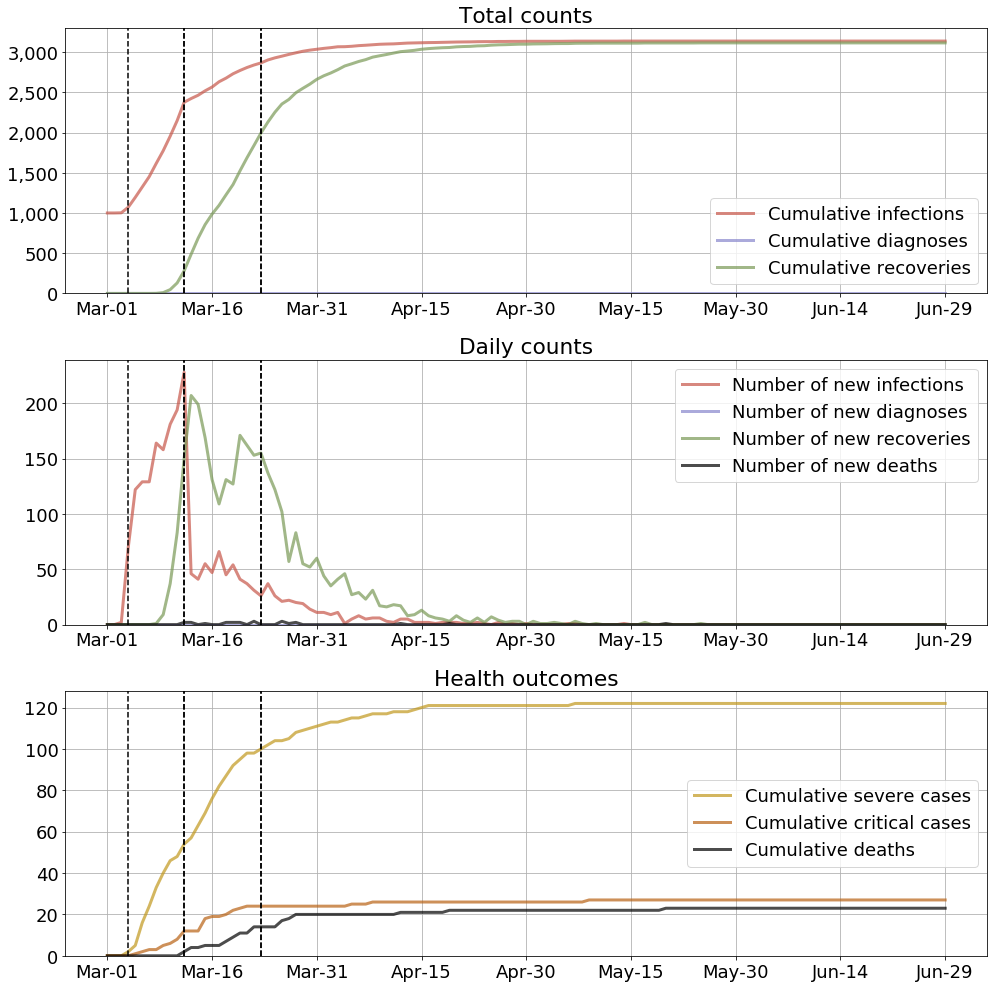

In [12]:
sim = cv.Sim(pars=simParams)
r = sim.run(do_plot=True, verbose=False)